# IMPORTING LIBRARIES!

In [1]:
import numpy as np
import pandas as pd
# import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
from tensorflow.keras.callbacks import ModelCheckpoint

#Import libraries |
import os

import matplotlib.pyplot as plt
import torch
%matplotlib inline
import seaborn as sns
import datetime as dt


# IMPORTING STOCKS DATASET AND CHECKING DEVICE : -

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train.head()


,Id,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,0,2033-03-01,159.271109,167.221488,157.380478,161.915062,160.167043,40490589,Company_0
1,1,2033-03-01,114.571843,114.409664,112.921505,113.066659,87.844722,8592865,Company_1
2,2,2033-03-01,50.984499,51.262529,50.266272,50.094499,49.329834,25085661,Company_2
3,3,2033-03-01,98.585428,99.988079,97.867719,98.811966,91.784469,823271,Company_3
4,4,2033-03-01,8874.646107,8935.704765,8811.247764,8873.173069,8407.389386,609369,Company_4


REFORMATTING THE DATAFRAME IN FORM OF COMPANY COLUMNS FOR BETTER EDA:

In [16]:
# Pivot the DataFrame
df_pivoted = train.pivot(index='Date', columns='Company', values=['Open', 'High', 'Low','Id','Close','Volume'])

# Flatten the MultiIndex columns
df_pivoted.columns = ['_'.join(col).strip() for col in df_pivoted.columns.values]

# Reset index for better structure
df_pivoted.reset_index(inplace=True)

# Display the result
df_pivoted.head()

,Date,Open_Company_0,Open_Company_1,Open_Company_2,Open_Company_3,Open_Company_4,Open_Company_5,High_Company_0,High_Company_1,High_Company_2,...,Close_Company_2,Close_Company_3,Close_Company_4,Close_Company_5,Volume_Company_0,Volume_Company_1,Volume_Company_2,Volume_Company_3,Volume_Company_4,Volume_Company_5
0,2033-03-01,159.271109,114.571843,50.984499,98.585428,8874.646107,136.430652,167.221488,114.409664,51.262529,...,50.094499,98.811966,8873.173069,135.882546,40490589.0,8592865.0,25085661.0,823271.0,609369.0,2576112.0
1,2033-03-05,158.049337,113.266631,50.534860,99.338531,8867.074823,135.100632,167.347904,113.161314,49.383999,...,49.250071,96.594597,8794.758109,135.970813,38792259.0,11677097.0,15073917.0,830714.0,388180.0,3945470.0
2,2033-03-06,163.686732,110.756424,49.838053,97.339020,8855.832360,137.119321,167.057890,112.339453,50.240192,...,48.878616,93.602065,8616.178598,136.070561,30423475.0,9907501.0,16314199.0,1287970.0,543686.0,6137704.0
3,2033-03-07,160.461622,109.827335,49.242896,93.144173,8621.791003,135.576175,161.422258,111.136768,49.930463,...,48.670564,90.718080,8679.165970,135.772818,36866132.0,9025097.0,22678239.0,1755708.0,598715.0,3130801.0
4,2033-03-08,150.289989,111.168595,48.728623,90.821417,8699.274117,136.789364,154.889808,111.415207,49.391428,...,47.642654,90.771456,8729.613528,137.854360,20664624.0,10079493.0,33250438.0,1441977.0,533856.0,5446693.0


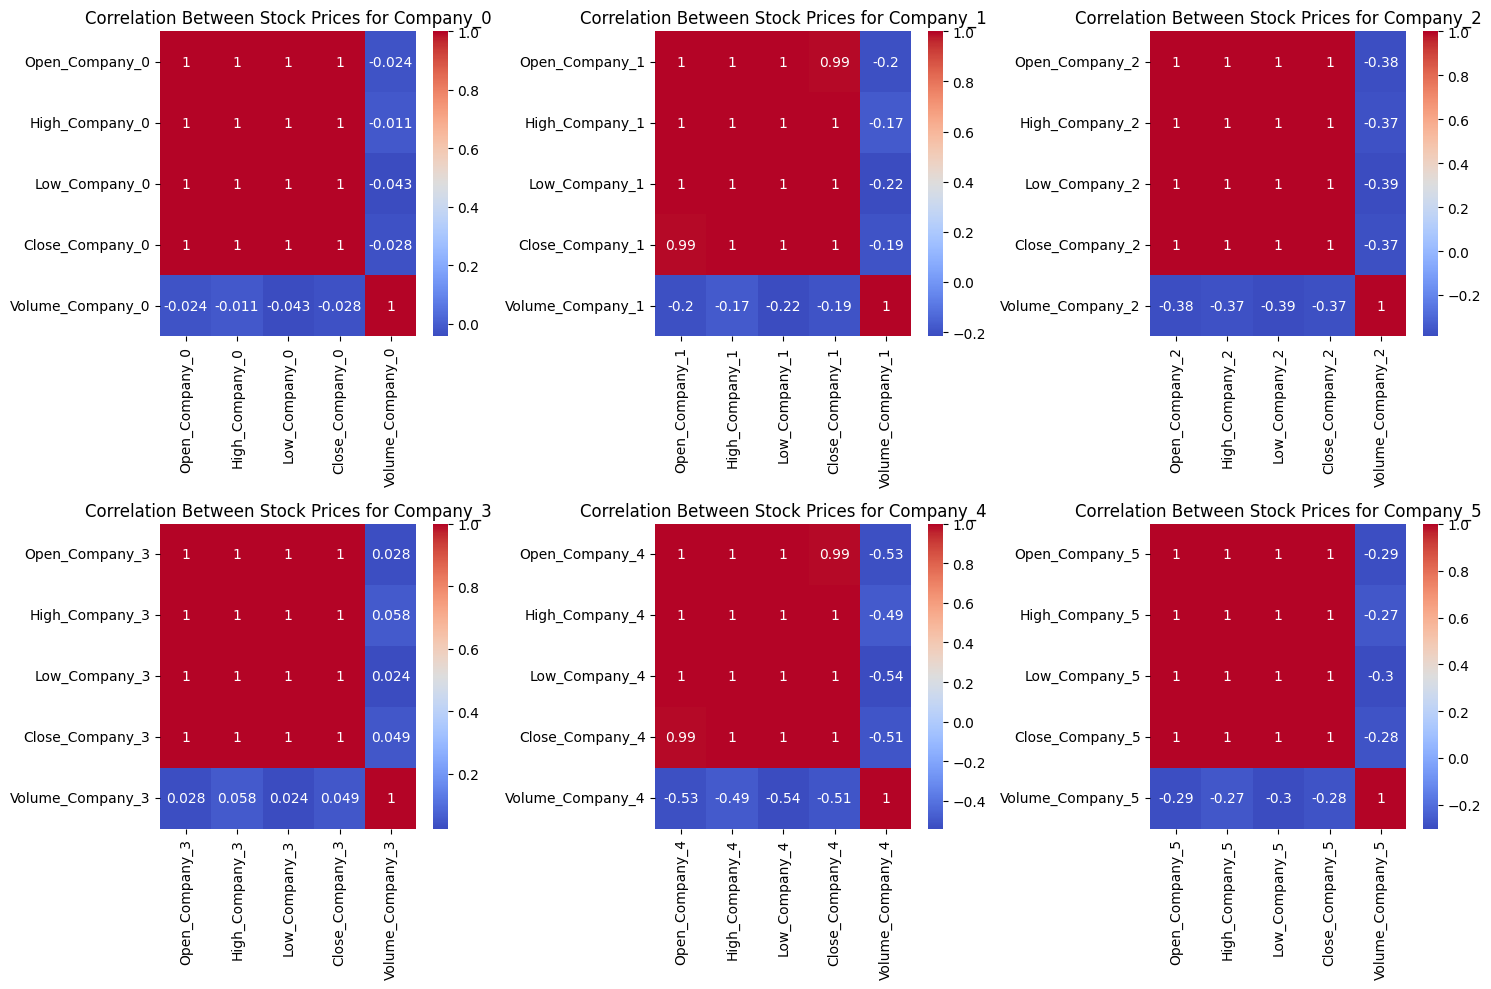

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

for i, ax in enumerate(axes):
    corr = df_pivoted[[f'Open_Company_{i}', f'High_Company_{i}', f'Low_Company_{i}', f'Close_Company_{i}', f'Volume_Company_{i}']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(f'Correlation Between Stock Prices for Company_{i}')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


Since there is very strong correlation between opening, Low, High and close prices hence dropping Open, High and Low prices columns will be beneficial to avoid muticollinearity.

In [19]:
#dropping non required columns
print(test.shape[0]/6)
print(test.shape) #hence we require 96 new data points
test.head(10)
print(train.shape)
train.describe()
train.isnull().sum() #no need for error handling ;)
# Pivot the DataFrame
df_pivoted = train.pivot(index='Date', columns='Company', values=['Open', 'High', 'Low', 'Volume','Id'])

# Flatten the MultiIndex columns
df_pivoted.columns = ['_'.join(col).strip() for col in df_pivoted.columns.values]

# Reset index for better structure
df_pivoted.reset_index(inplace=True)

# Display the result
df_pivoted.head()
# Pivot the DataFrame
df_closing = train.pivot(index='Date', columns='Company', values=['Close'])

# Flatten the MultiIndex columns
df_closing.columns = ['_'.join(col).strip() for col in df_closing.columns.values]

# Reset index for better structure
df_closing.reset_index(inplace=True)

# Display the result
df_closing.head()


96.0
(576, 3)
(7416, 9)


,Date,Close_Company_0,Close_Company_1,Close_Company_2,Close_Company_3,Close_Company_4,Close_Company_5
0,2033-03-01,161.915062,113.066659,50.094499,98.811966,8873.173069,135.882546
1,2033-03-05,163.108507,110.561246,49.250071,96.594597,8794.758109,135.970813
2,2033-03-06,161.716298,109.651386,48.878616,93.602065,8616.178598,136.070561
3,2033-03-07,148.051907,109.723772,48.670564,90.718080,8679.165970,135.772818
4,2033-03-08,148.483368,109.118052,47.642654,90.771456,8729.613528,137.854360


# Closing Price Analysis

In [7]:
#checking if there are null values or not
df_closing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1236 non-null   object 
 1   Close_Company_0  1236 non-null   float64
 2   Close_Company_1  1236 non-null   float64
 3   Close_Company_2  1236 non-null   float64
 4   Close_Company_3  1236 non-null   float64
 5   Close_Company_4  1236 non-null   float64
 6   Close_Company_5  1236 non-null   float64
dtypes: float64(6), object(1)
memory usage: 67.7+ KB


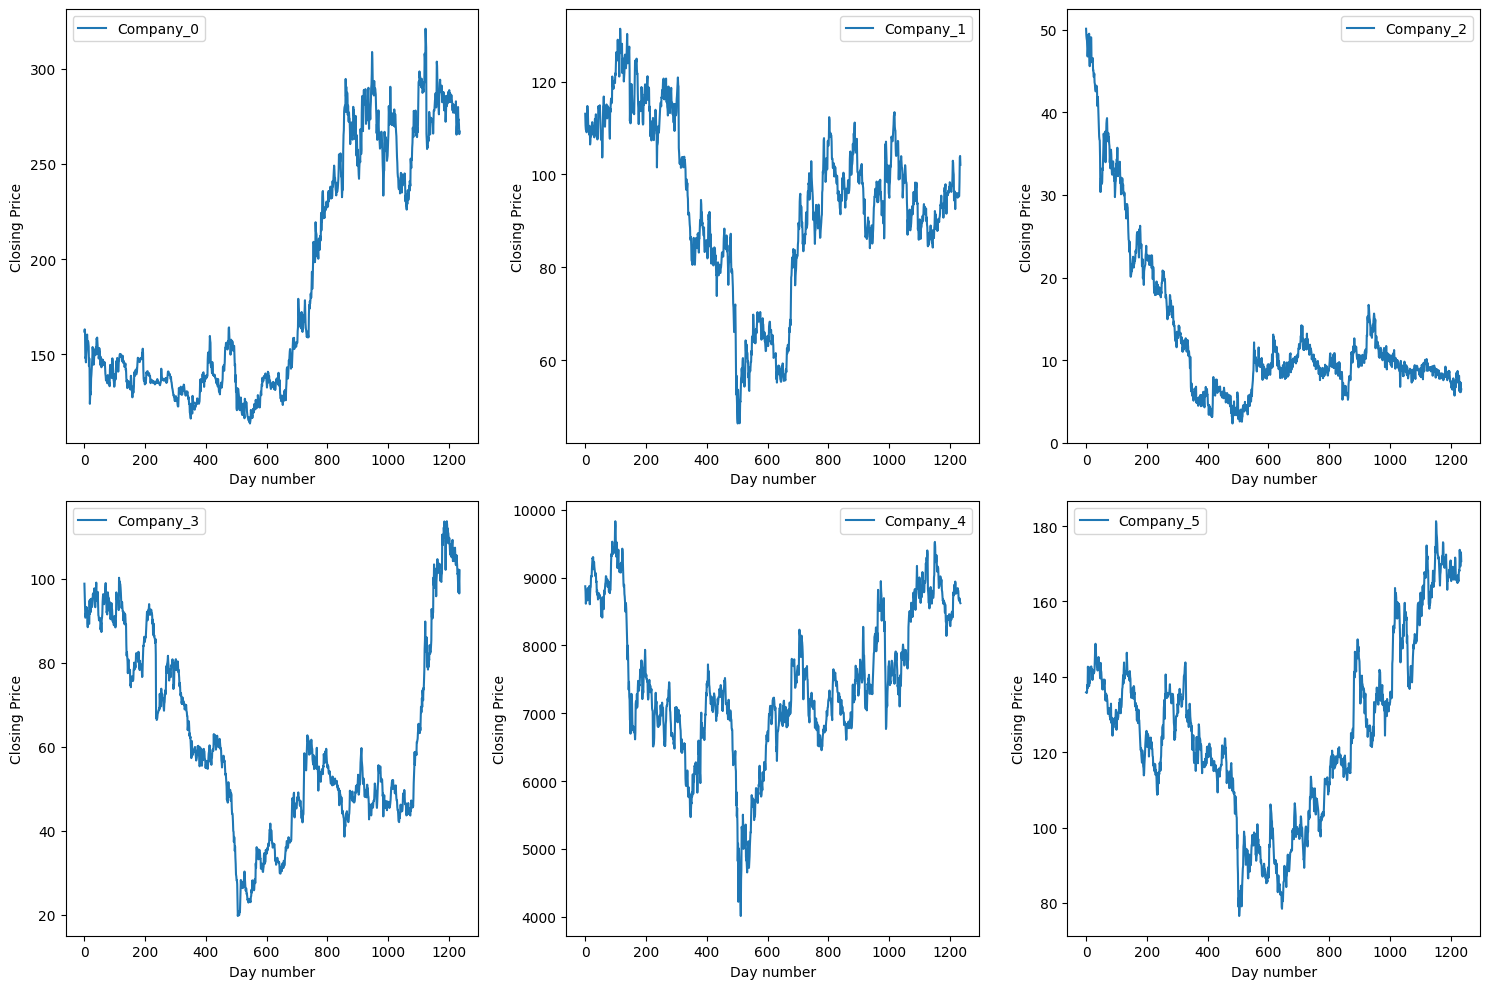

In [9]:
# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

for i in range(6):
    column_name = f'Close_Company_{i}'
    # Plot on the respective subplot
    axes[i].plot(df_closing[column_name], label=f'Company_{i}')
    axes[i].set_xlabel('Day number')
    axes[i].set_ylabel('Closing Price')
    axes[i].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


In [10]:
#checking mean, standard deviation, and percentiles of dataframe
df_closing.describe()

,Close_Company_0,Close_Company_1,Close_Company_2,Close_Company_3,Close_Company_4,Close_Company_5
count,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000
mean,187.377773,93.931299,13.353915,62.444512,7444.989100,125.695848
std,62.747050,18.167489,9.755487,22.757490,1060.563433,23.374445
min,113.647274,46.365574,2.358517,19.697281,4011.679346,76.540317
25%,135.368755,85.024641,8.084282,46.284757,6846.206442,111.038010
50%,150.766672,95.260250,9.752251,57.087407,7303.319816,125.531778
75%,257.359367,108.194856,14.204564,80.529996,8412.829106,140.019667
max,321.068062,131.375054,50.094499,113.678904,9832.117608,181.283859


From the above table we can observe that range of close prices of company_4 is maximum. If there is even slight wrong prediction then there is a very wide variation in the RMSE value of the overall output.

Hence we need to train the model for Company_4 very carefully so that output has low RMSE.

From the above table we can see that there are no any outliers but we will verify it again later by plotting the Boxplot.

PLOTTING MEAN LINE ABOUT EACH COMPANY CLOSE VALUES : -

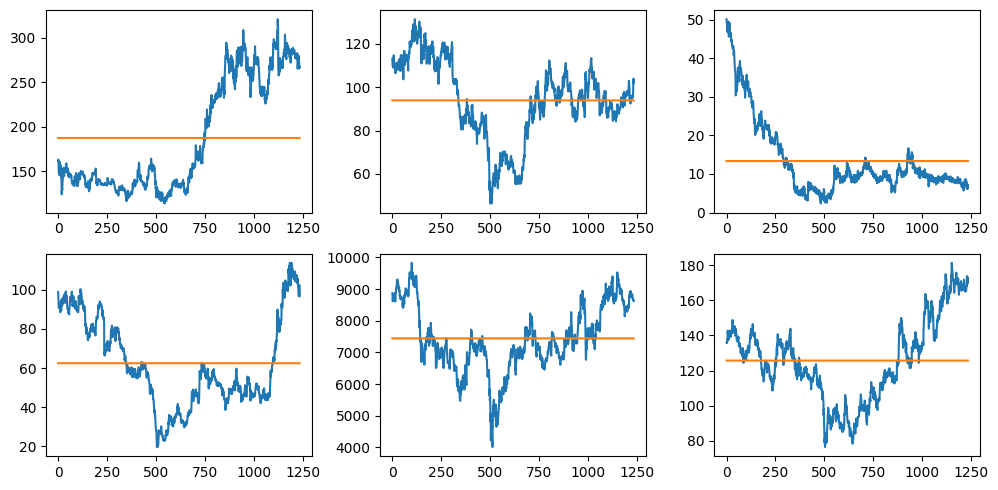

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Iterate through columns and plot data
for i in range(1, 7):
    row_index = (i - 1) // 3
    col_index = (i - 1) % 3

    axes[row_index, col_index].plot(df_closing.iloc[:, i])
    axes[row_index, col_index].plot([df_closing.describe().iloc[1, i-1] for _ in range(1236)])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


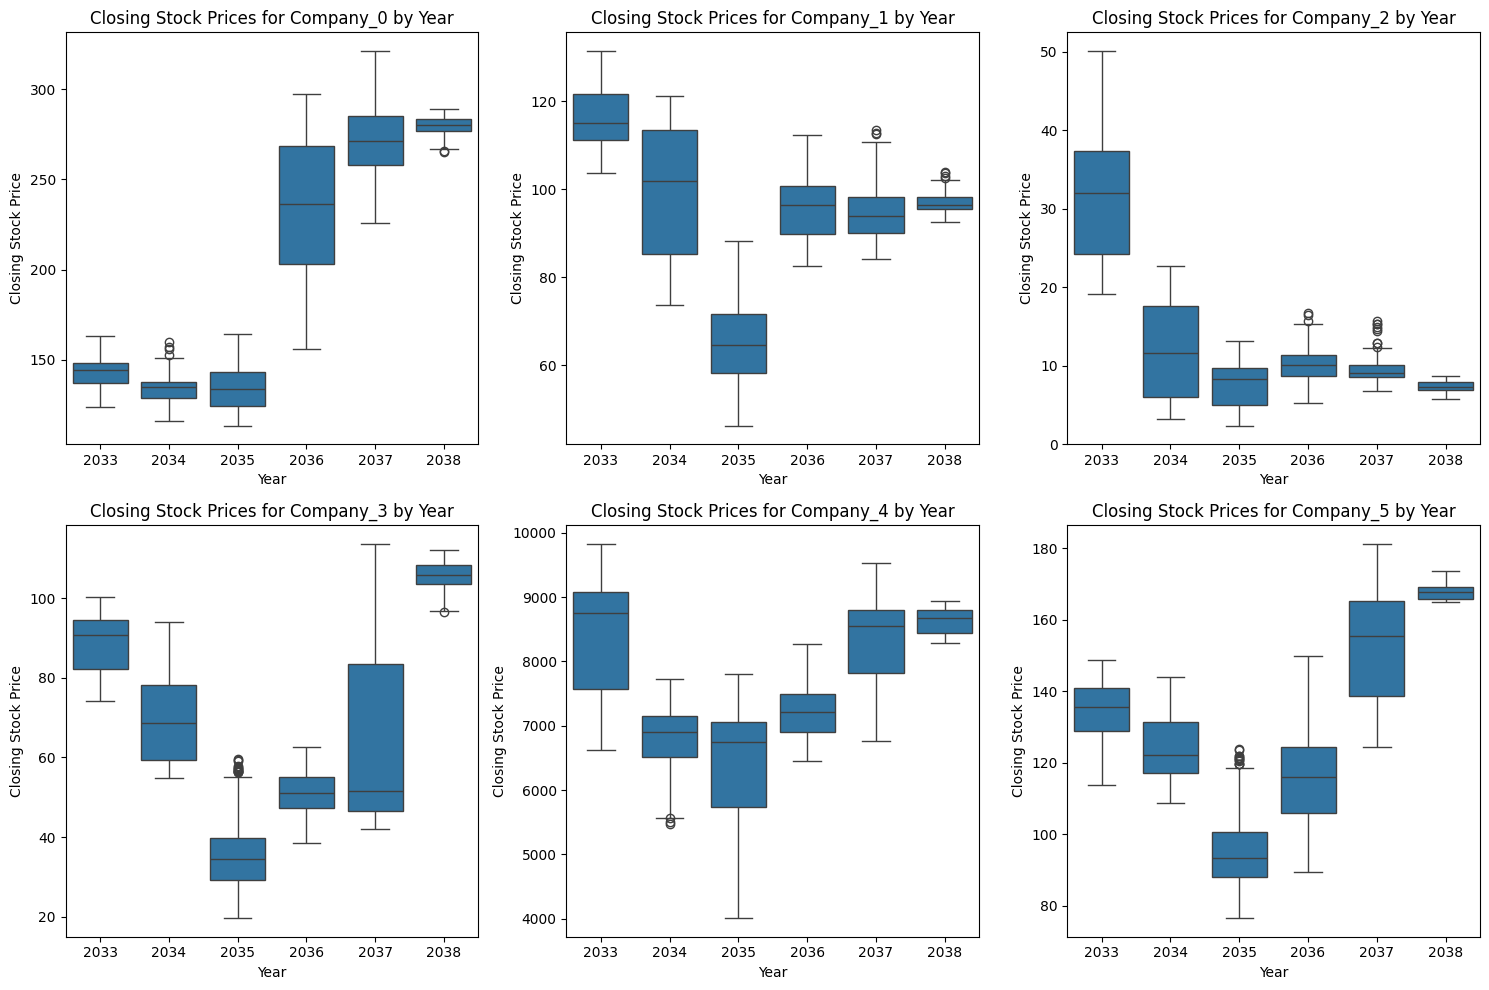

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df_closing' is your DataFrame with columns 'Date', 'Close_Company_0', ..., 'Close_Company_5'
df_closing['Date'] = pd.to_datetime(df_closing['Date'])

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

for i, ax in enumerate(axes):
    df_closing[f'year_{i}'] = df_closing['Date'].dt.year
    sns.boxplot(y=f'Close_Company_{i}', x=f'year_{i}', data=df_closing, ax=ax)
    ax.set_title(f'Closing Stock Prices for Company_{i} by Year')
    ax.set_ylabel('Closing Stock Price')
    ax.set_xlabel('Year')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()




Clearly we can see that there is no significant outlier that affects our results.

We can see some outliers in this data in some years but that will not affect our data.

# TRAINING VALIDATION : -

In [ ]:
# loss=0
# for i in range(6):

#   df_test=df_closing[f'Close_Company_{i}'][-96:].reset_index()
#   print(df_test)
#   df_closing[f'Close_Company_{i}']=df_closing[f'Close_Company_{i}'][:-96]

#   df = df_closing[[f'Close_Company_{i}']][:-96]
#   print(df_test.shape,df.shape)
#   from sklearn.preprocessing import MinMaxScaler

#   # scaler = MinMaxScaler(feature_range = (0,1))
#   # y = scaler.fit_transform(df['Close_Company_0'])

#   # # download the data
#   # df = yf.download(tickers=['AAPL'], period='1y')
#   y = df[f'Close_Company_{i}'].fillna(method='ffill')
#   y = y.values.reshape(-1, 1)

#   # # scale the data
#   scaler = MinMaxScaler(feature_range=(-1, 1))
#   scaler = scaler.fit(y)
#   y = scaler.transform(y)

#   # generate the input and output sequences
#   n_lookback = 250  # length of input sequences (lookback period)
#   n_forecast = 96 # length of output sequences (forecast period)

#   X = []
#   Y = []

#   for j in range(n_lookback, len(y) - n_forecast + 1):
#       X.append(y[j - n_lookback: j])
#       Y.append(y[j: j + n_forecast])

#   X = np.array(X)
#   Y = np.array(Y)

#   # fit the model
#   model = Sequential()
#   # model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
#   # model.add(LSTM(units=50))
#   # model.add(Dense(n_forecast))

#   model.add(LSTM(units = 128, return_sequences= True, input_shape = (n_lookback, 1)))
#   model.add(Dropout(0.1))
#   model.add(LSTM(units = 128, return_sequences= True))
#   model.add(Dropout(.1))
#   model.add(LSTM(units = 128, return_sequences= True))
#   # model.add(Dropout (0.2))
#   model.add(LSTM(units = 128))
#   model.add(Dropout(.1))
#   model.add(Dense(n_forecast))

#   model.compile(loss='mean_squared_error', optimizer='adam')
#   model.fit(X, Y, epochs=100, batch_size=32)

#   # generate the forecasts
#   X_ = y[- n_lookback:]  # last available input sequence
#   X_ = X_.reshape(1, n_lookback, 1)

#   Y_ = model.predict(X_).reshape(-1, 1)
#   Y_ = scaler.inverse_transform(Y_)

#   # organize the results in a data frame
#   df_past = df[f'Close_Company_{i}'].reset_index()
#   df_past.rename(columns={f'Close_Company_{i}': 'Actual'}, inplace=True)
#   # df_past['Date'] = pd.to_datetime(df_past['Date'])
#   df_past['Forecast'] = np.nan
#   df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

#   df_future = pd.DataFrame(columns=[ 'Actual', 'Forecast'])
#   # df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
#   df_future['Forecast'] = Y_.flatten()
#   df_future['Actual'] = np.nan
#   print(df_future.shape)
#   results = df_past["Actual"].append(df_future["Forecast"]).reset_index()
#   # final.append(Y_.flatten())
#   # plot the results
#   from sklearn.metrics import mean_squared_error
#   print(df.shape)
#   print(Y_.flatten().shape)
#   print(df_test.shape)
#   print(df_test)
#   rms = mean_squared_error(df_test[f'Close_Company_{i}'], Y_.flatten(), squared=False)
#   print(f'RMSE : {rms}')
#   loss=loss+rms
#   plt.plot([x for x in range(1236-96) ],df_past["Actual"])
#   plt.plot([x for x in range(1237-96,1237)],df_future["Forecast"])
#   plt.plot([x for x in range(1237-96,1237)],df_test[f"Close_Company_{i}"])
#   plt.show()
# print("Total loss = ",loss)

In [ ]:
# print(df_future.shape)
# results = df_past["Actual"].append(df_future["Forecast"]).reset_index()

# # plot the results
# plt.plot([x for x in range(1236) ],df_past["Actual"])
# plt.plot([x for x in range(1237,1237+96)],df_future["Forecast"])
# plt.show()

PREPROCESSING AND MODEL FITTING

Epoch 1/19
28/28 [==============================] - 9s 45ms/step - loss: 0.1501
Epoch 2/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0522
Epoch 3/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0441
Epoch 4/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0379
Epoch 5/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0464
Epoch 6/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0395
Epoch 7/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0404
Epoch 8/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0347
Epoch 9/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0348
Epoch 10/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0344
Epoch 11/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0316
Epoch 12/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0291
Epoch 13/19
28/28 [==================

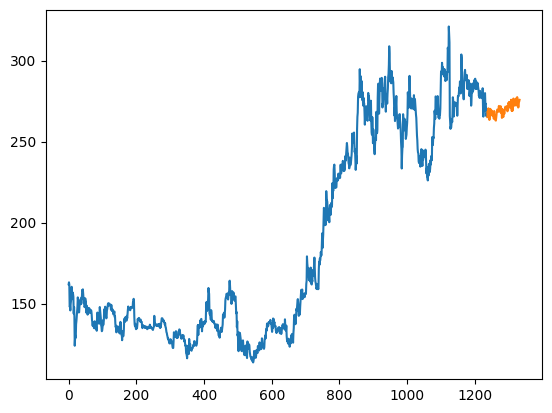

Epoch 1/19
28/28 [==============================] - 6s 44ms/step - loss: 0.0873
Epoch 2/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0707
Epoch 3/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0542
Epoch 4/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 5/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 6/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0486
Epoch 7/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0400
Epoch 8/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0406
Epoch 9/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0475
Epoch 10/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0384
Epoch 11/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0337
Epoch 12/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0304
Epoch 13/19
28/28 [==================

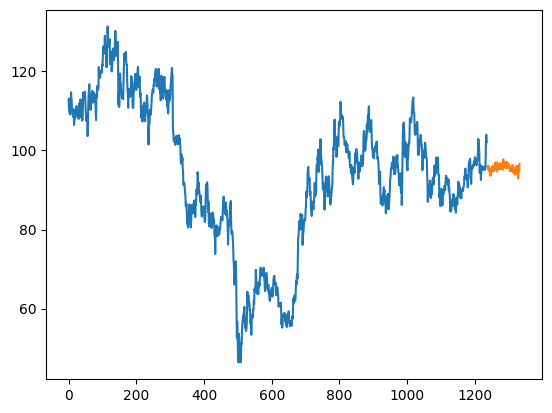

Epoch 1/19
28/28 [==============================] - 6s 44ms/step - loss: 0.1431
Epoch 2/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0146
Epoch 3/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0117
Epoch 4/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0123
Epoch 5/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0130
Epoch 6/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0110
Epoch 7/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0129
Epoch 8/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0127
Epoch 9/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0114
Epoch 10/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0105
Epoch 11/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0107
Epoch 12/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0099
Epoch 13/19
28/28 [==================

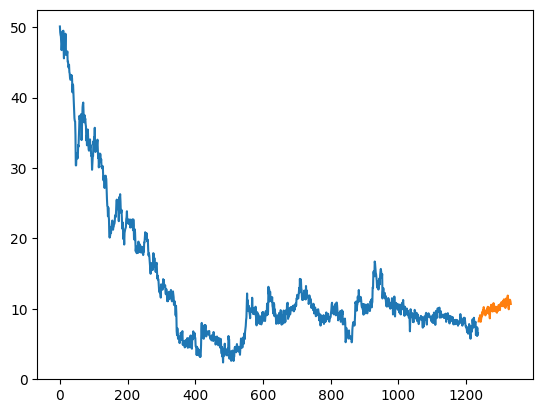

Epoch 1/19
28/28 [==============================] - 6s 45ms/step - loss: 0.1418
Epoch 2/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0941
Epoch 3/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0842
Epoch 4/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0769
Epoch 5/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0708
Epoch 6/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0777
Epoch 7/19
28/28 [==============================] - 1s 38ms/step - loss: 0.0831
Epoch 8/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0697
Epoch 9/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0738
Epoch 10/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0600
Epoch 11/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 12/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0532
Epoch 13/19
28/28 [==================

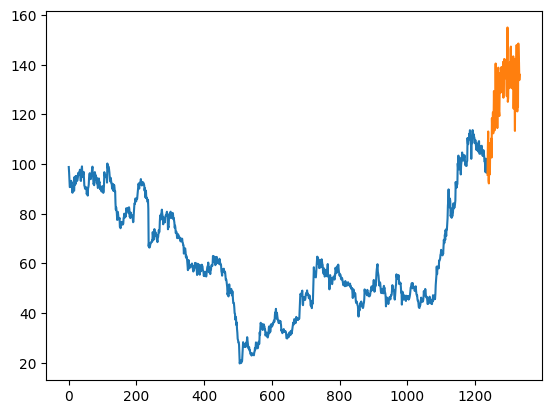

Epoch 1/19
28/28 [==============================] - 7s 44ms/step - loss: 0.0856
Epoch 2/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0667
Epoch 3/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 4/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 5/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0597
Epoch 6/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 7/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 8/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0541
Epoch 9/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 10/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0487
Epoch 11/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0625
Epoch 12/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0464
Epoch 13/19
28/28 [==================

1/1 [==============================] - 1s 870ms/step
(96, 2)


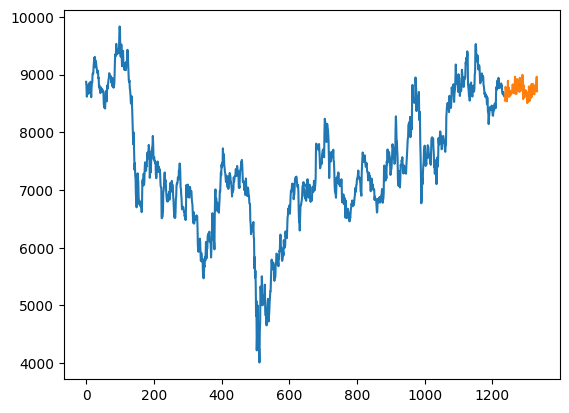

Epoch 1/19
28/28 [==============================] - 7s 44ms/step - loss: 0.1168
Epoch 2/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0731
Epoch 3/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0655
Epoch 4/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0549
Epoch 5/19
28/28 [==============================] - 1s 41ms/step - loss: 0.0578
Epoch 6/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0546
Epoch 7/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0506
Epoch 8/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0512
Epoch 9/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0551
Epoch 10/19
28/28 [==============================] - 1s 40ms/step - loss: 0.0540
Epoch 11/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0512
Epoch 12/19
28/28 [==============================] - 1s 39ms/step - loss: 0.0551
Epoch 13/19
28/28 [==================

1/1 [==============================] - 1s 886ms/step
(96, 2)


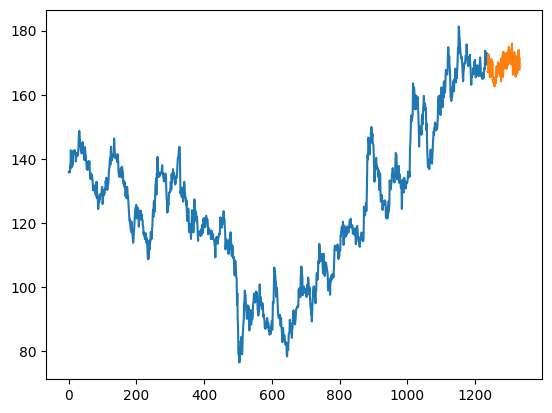

In [ ]:
final=[]
for i in range(6):


  df = df_closing[[f'Close_Company_{i}']]
  #print(df_test.shape,df.shape)
  from sklearn.preprocessing import MinMaxScaler

  # scaler = MinMaxScaler(feature_range = (0,1))
  # y = scaler.fit_transform(df['Close_Company_0'])

  # # download the data
  # df = yf.download(tickers=['AAPL'], period='1y')
  y = df[f'Close_Company_{i}'].fillna(method='ffill')
  y = y.values.reshape(-1, 1)

  # # scale the data
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(y)
  y = scaler.transform(y)

  # generate the input and output sequences
  n_lookback = 249  # length of input sequences (lookback period)
  n_forecast = 96 # length of output sequences (forecast period)


  X = []
  Y = []

  for j in range(n_lookback, len(y) - n_forecast + 1):
      X.append(y[j - n_lookback: j])
      Y.append(y[j: j + n_forecast])

  X = np.array(X)
  Y = np.array(Y)
#_________________________________________________________________________________________________________________#
  # # fit the model
  # model = Sequential()
  # # model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
  # # model.add(LSTM(units=50))
  # # model.add(Dense(n_forecast))

  # model.add(LSTM(units = 128, return_sequences= True, input_shape = (n_lookback, 1)))
  # # model.add(Dropout(0.1))
  # model.add(LSTM(units = 128, return_sequences= True,))
  # # model.add(Dropout(.1))
  # model.add(LSTM(units = 128, return_sequences= True,))
  # # model.add(Dropout (0.2))
  # model.add(LSTM(units = 128))
  # model.add(Dropout(.1))
  # model.add(Dense(n_forecast))

#   model = tf.keras.models.Sequential([
#                                       tf.keras.layers.LSTM(200, input_shape = (n_lookback, 1),  return_sequences = True),
#                                       tf.keras.layers.LSTM(200),
#                                       tf.keras.layers.Dense(512, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(256, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(128, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(n_forecast)
#                                       ])

#_________________________________________________________________________________________________________________#
  #Model Architecture

  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, input_shape=(n_lookback, 1), return_sequences=True),
    tf.keras.layers.LSTM(200, return_sequences=True),

    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(n_forecast)
])

#_________________________________________________________________________________________________________________#

# # Define the filepath where you want to save the model
#   filepath = "/content/model/model.h5"

# # Define the ModelCheckpoint callback
#   checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#_________________________________________________________________________________________________________________#

  model.compile(loss='mean_squared_error', optimizer='adam')
    # Save the model's weights
  model.save_weights(f'/content/model/model_weights_{i}.h5')
  model.fit(X, Y, epochs=19, batch_size=33)

#_________________________________________________________________________________________________________________#

  # generate the forecasts
  X_ = y[- n_lookback:]  # last available input sequence
  X_ = X_.reshape(1, n_lookback, 1)

  Y_ = model.predict(X_).reshape(-1, 1)
  Y_ = scaler.inverse_transform(Y_)

#_________________________________________________________________________________________________________________#

  # organize the results in a data frame
  df_past = df[f'Close_Company_{i}'].reset_index()
  df_past.rename(columns={f'Close_Company_{i}': 'Actual'}, inplace=True)
  # df_past['Date'] = pd.to_datetime(df_past['Date'])
  df_past['Forecast'] = np.nan
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

  df_future = pd.DataFrame(columns=[ 'Actual', 'Forecast'])
  # df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
  df_future['Forecast'] = Y_.flatten()
  df_future['Actual'] = np.nan
  print(df_future.shape)
#   results = df_past["Actual"].append(df_future["Forecast"]).reset_index()
  results=pd.concat([df_past["Actual"],df_future["Forecast"]],ignore_index=True)
  final.append(Y_.flatten())
# plot the results
  plt.plot([x for x in range(1236)], df_past["Actual"])
  plt.plot([x for x in range(1237, 1237 + 96)], df_future["Forecast"])
  plt.show()

In [ ]:
np.array(final).T

array([[2.65122528e+02, 9.57968826e+01, 8.20035458e+00, 9.57076416e+01,
        8.54803809e+03, 1.67208740e+02],
       [2.68864319e+02, 9.61557083e+01, 8.46249199e+00, 1.06446693e+02,
        8.61454297e+03, 1.67004669e+02],
       [2.66419250e+02, 9.61784592e+01, 8.69015789e+00, 1.13120003e+02,
        8.78601367e+03, 1.68086411e+02],
       [2.70528015e+02, 9.54655457e+01, 8.34926987e+00, 9.34213333e+01,
        8.73727539e+03, 1.72590073e+02],
       [2.64999420e+02, 9.49864655e+01, 9.07711220e+00, 9.22045670e+01,
        8.73677539e+03, 1.68372665e+02],
       [2.68704834e+02, 9.58503952e+01, 8.91257095e+00, 1.00169281e+02,
        8.62450293e+03, 1.70990646e+02],
       [2.63376465e+02, 9.46989670e+01, 8.13856030e+00, 9.65077057e+01,
        8.53451953e+03, 1.68661804e+02],
       [2.66222778e+02, 9.48780975e+01, 8.37237930e+00, 9.58398590e+01,
        8.67738867e+03, 1.65495361e+02],
       [2.70216034e+02, 9.52823334e+01, 8.71796608e+00, 1.08530479e+02,
        8.62467969e+03, 

REQUIRED OUTPUT CSV FILES : -

In [ ]:
ans=pd.DataFrame()
ans["Id"]=test["Id"]
ans["Close"]=np.array(final).T.reshape(-1,1)
ans.to_csv('/content/model/submission34.csv',index=False)

DOWNLOADING WEIGHTS OF EACH COMPANY WISE MODELS : -

In [ ]:
from google.colab import files
for i in range(6):
  files.download(f'/content/model/model_weights_{i}.h5')

files.download('/content/model/submission34.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>